## MAKEMORE: becoming a backprop ninja

In [168]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words)))) # alphabet
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3

# function to build data set with train/dev/test splits
def build_dataset(words):
    X, Y = [], []  # X is input, Y is label
    for w in words:
        context = [0] * block_size # initialize context by padding with 0
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop & append

    X = torch.tensor(X) # X contains indexes of input letters
    Y = torch.tensor(Y) # Y contains indexes of output letters
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()

    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [8]:
n_embd = 10 # the dimensionality of the characeter embedding vectors
n_hidden = 64 # no. of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),                   generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden),       generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                              generator=g) * 0.1 # using b1 just for fun, it is useless because of batchNorm layer

# Layer 2
W2 = torch.randn((n_hidden, vocab_size),                generator=g) * 0.1
b2 = torch.randn(vocab_size,                            generator=g) * 0.1

# BatchNorm parameters
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [9]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience

# minibatch construct
ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X, y


Note on Batch Norm
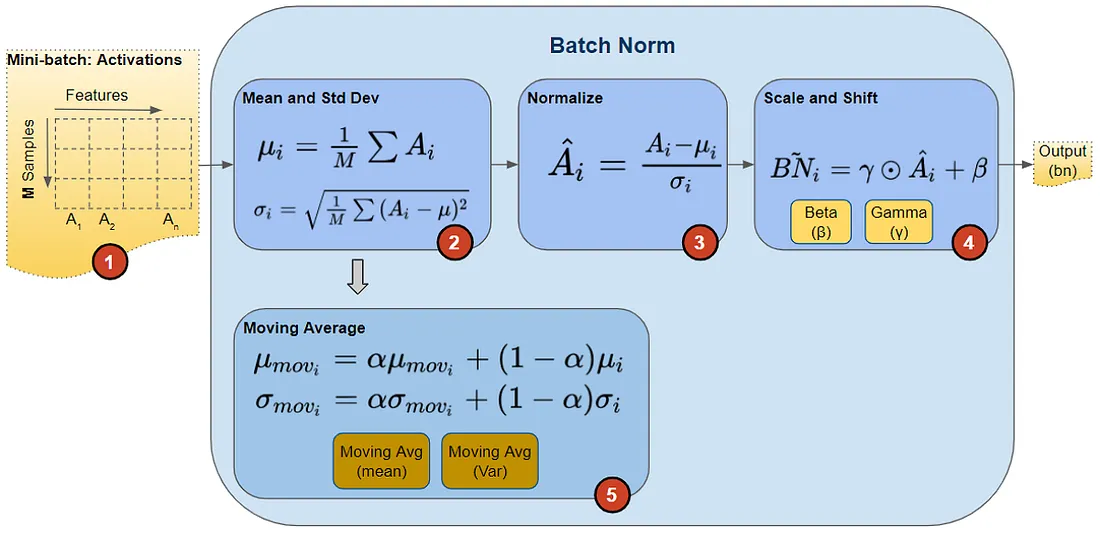

In [10]:
# chunkated into smaller steps that are possible to backward one at a time
# forward pass
emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2
# Cross entropy loss (same as F.cross_entropy(logist, Yb))
logit_maxes = logits.max(1, keepdim=True).values # similar to logits * one_hot matrix presenting indices of max values along the row (F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * logits).sum(1, keepdim=True)
norm_logits = logits - logit_maxes  # subtract max for numerical stability
counts = norm_logits.exp()          # exponential
counts_sum = counts.sum(1, keepdim=True) # sum of exponentials
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# Pytorch backward pass
for p in parameters:
    p.grad = None

for t in[logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani, embcat, emb]:
    t.retain_grad()

loss.backward()
loss

tensor(3.3182, grad_fn=<NegBackward0>)

## Exercise 1
- Back prop through the whole thing manually

In [332]:
# Back propagation - derivatives should have the same shape as the original

# --- Cross-entropy --- #
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n),Yb] = -1.0/n
dprobs = 1.0/probs * dlogprobs # chain rule
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True) # sum across columns
dcounts_sum = -1.0 * counts_sum**-2 * dcounts_sum_inv
dcounts = (counts_sum_inv * dprobs) # Branch 1 of counts grad - dcounts = (counts_sum_inv * dprobs)
dcounts += (torch.ones_like(counts) * dcounts_sum) # Branch 2 of counts grad - dcounts = (dcounts_sum)
dnorm_logits = norm_logits.exp() * dcounts
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True) # Alternative answer: torch.zeros_like(dnorm_logits) a.k.a 0, as changeing logit_maxes does not affect loss
dlogits = dnorm_logits.clone() # exact copy as dnorm_logits flows through sum operation
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes # one-hot matrix representing indices of max value (along each row) multiply with dlogit_maxes

# --- Linear layer 2 --- #
db2 = dlogits.sum(0) # sum over rows i.e., individual batches
dh = dlogits @ W2.T
dW2 = h.T @ dlogits

# --- Non-linear layer --- #
dhpreact = (1.0 - h**2) * dh

# --- Batch Norm layer --- #
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnbias = dhpreact.sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnvar_inv = (bndiff *dbnraw).sum(0, keepdim=True)
dbnvar = -0.5*(bnvar + 1e-5)**-1.5 * dbnvar_inv
dbndiff2 = 1/(n-1) * torch.ones_like(bndiff2) * dbnvar # replication by multiplying with torch.ones_likes(bndiff2)
dbndiff = bnvar_inv*dbnraw
dbndiff += 2*bndiff*dbndiff2
dbnmeani = (-torch.ones_like(bndiff)*dbndiff).sum(0, keepdim=True)
dhprebn = dbndiff.clone() # need to clone to get the copy
dhprebn += 1.0/n*dbnmeani*torch.ones_like(hprebn)
db1 = dhprebn.sum(0, keepdim=True)
dW1 = embcat.T @ dhprebn
dembcat = dhprebn @ W1.T
demb = dembcat.view(emb.shape) # reshape as emb.shape
dC = torch.zeros_like(C)

# Route the gradient demb back to dC. if any rows in C are used more than once, its gradient must be added together
# for k in range(Xb.shape[0]):
#     for j in range(Xb.shape[1]):
#         ix = Xb[k,j]
#         dC[ix] += demb[k,j] # multiple occurrences are to be added
Xb_oh = F.one_hot(Xb, num_classes = 27).float() # Convert the selection operation into a selection matrix, where emb = C[Xb] <-> (Xb_oh @ C).view(n, block_size, n_embd)
dC = (Xb_oh.permute(0,2,1) @ demb).sum(0) # Differentiate like any other matrix operation (dC = Xb_oh.T @ demb; indices to track the batch dimensions)

In [333]:
# Verification
cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('b2', db2, b2)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani )
cmp('hprebn', dhprebn, hprebn)
cmp('b1', db1, b1)
cmp('W1', dW1, W1)
cmp('embcat', dembcat, embcat)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

Note:
- if forward pass is replication through broadcasting, backward pass will be summation
- if forward pass is summation, backward pass will involve replication (boardcasting)
- Backward pass of matrix multiplication is matrix multiplication
- Gradient flows through summation without being altered

## Exercise 2
- back prop through the cross-entropy but all in one go by simplifying the expression of the loss `dLoss/dlogits`
- softmax 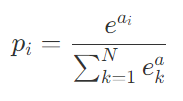
- cross-entroy 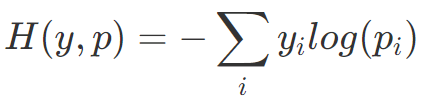

In [340]:
dlogits = probs*F.one_hot(Yb, num_classes=vocab_size) - F.one_hot(Yb, num_classes=vocab_size)

In [341]:
logits.shape, dlogits.shape

(torch.Size([32, 27]), torch.Size([32, 27]))

In [342]:
cmp('logits', dlogits, logits)

logits          | exact: False | approximate: False | maxdiff: 0.9552461504936218
